In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamPredictor
import numpy as np

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

def dice_coefficient(mask1, mask2):
    intersection = np.sum(np.logical_and(mask1, mask2))
    union = np.sum(np.logical_or(mask1, mask2))
    
    dice = (2.0 * intersection) / (union + intersection)
    return dice

In [3]:
# 预处理文件路径
import nibabel as nib
import glob
import os
training_train = [1,2,3,4,5,6,7,8,9,10,21,22,23,24,25,26,27,28,29,30,31,32,33,34]
training_test =[35,36,37,38,39,40]
training=[1,2,3,4,5,6,7,8,9,10,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40]
image_dir = 'RawData/Training/imagesTr'
label_dir = 'RawData/Training/labelsTr'

In [4]:
total_unique_gray_val = set()
for T in training:
    # 找到图片和标签的路径
    image_filename = f"img{str(T).zfill(4)}.nii.gz"
    image_path = os.path.join(image_dir, image_filename)
    file_img = nib.load(image_path)
    data_img = file_img.get_fdata()

    label_filename = f"label{str(T).zfill(4)}.nii.gz"
    label_path = os.path.join(label_dir, label_filename)
    file_label = nib.load(label_path)
    data_label = file_label.get_fdata()

    total_img = data_img.shape[2]

    # 找到所有可能的灰度值，也就是所有不同的器官
    for picnum in range(total_img):
        slice_normalized_label = cv2.normalize(data_label[:,:,picnum], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        slice_8bit_label = np.uint8(slice_normalized_label)
        non_zero_values = np.unique(slice_8bit_label[slice_8bit_label != 0])
        total_unique_gray_val.update(non_zero_values)
# 计算灰度值的种类数
total_num_grays = len(total_unique_gray_val)

In [5]:
X_train = []
y_train = []

for T in training_train:
    # 找到图片和标签的路径
    image_filename = f"img{str(T).zfill(4)}.nii.gz"
    image_path = os.path.join(image_dir, image_filename)
    file_img = nib.load(image_path)
    data_img = file_img.get_fdata()

    label_filename = f"label{str(T).zfill(4)}.nii.gz"
    label_path = os.path.join(label_dir, label_filename)
    file_label = nib.load(label_path)
    data_label = file_label.get_fdata()

    total_img = data_img.shape[2]

    for picnum in range(total_img):
        slice_normalized_label = cv2.normalize(data_label[:,:,picnum], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        slice_8bit_label = np.uint8(slice_normalized_label)
        slice_bgr_label = cv2.cvtColor(slice_8bit_label, cv2.COLOR_GRAY2BGR)

        # 分解出所有像素点
        h, w = slice_8bit_label.shape
        nonzero_mask = slice_8bit_label != 0
        y_coords, x_coords = np.nonzero(nonzero_mask)
        gray_values = slice_8bit_label[nonzero_mask]
        pixel_data_label = list(zip(x_coords, y_coords, gray_values))
        pixel_data_array_label = np.array(pixel_data_label, dtype=np.int32)

        if pixel_data_array_label.shape[0] == 0 :
            continue
        unique_gray_values = np.unique(pixel_data_array_label[:, 2])
        for color in unique_gray_values:
            new_space = np.array(slice_normalized_label)
            new_space[new_space != color] = 0
            X_train.append(new_space)
            for i, tmp in enumerate(total_unique_gray_val):
                if color == tmp:
                    y_train.append(i)
                    break


In [6]:
X_val = []
y_val = []

for T in training_test:
    # 找到图片和标签的路径
    image_filename = f"img{str(T).zfill(4)}.nii.gz"
    image_path = os.path.join(image_dir, image_filename)
    file_img = nib.load(image_path)
    data_img = file_img.get_fdata()

    label_filename = f"label{str(T).zfill(4)}.nii.gz"
    label_path = os.path.join(label_dir, label_filename)
    file_label = nib.load(label_path)
    data_label = file_label.get_fdata()

    total_img = data_img.shape[2]
    
    for picnum in range(total_img):
        slice_normalized_label = cv2.normalize(data_label[:,:,picnum], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
        slice_8bit_label = np.uint8(slice_normalized_label)
        slice_bgr_label = cv2.cvtColor(slice_8bit_label, cv2.COLOR_GRAY2BGR)

        # 分解出所有像素点
        h, w = slice_8bit_label.shape
        nonzero_mask = slice_8bit_label != 0
        y_coords, x_coords = np.nonzero(nonzero_mask)
        gray_values = slice_8bit_label[nonzero_mask]
        pixel_data_label = list(zip(x_coords, y_coords, gray_values))
        pixel_data_array_label = np.array(pixel_data_label, dtype=np.int32)

        # 获取灰度值的种类
        if pixel_data_array_label.shape[0] == 0 :
            continue
        unique_gray_values = np.unique(pixel_data_array_label[:, 2])
        for color in unique_gray_values:
            new_space = np.array(slice_normalized_label)
            new_space[new_space != color] = 0
            X_val.append(new_space)
            for i, tmp in enumerate(total_unique_gray_val):
                if color == tmp:
                    y_val.append(i)
                    break

In [7]:
# 构造CNN
# 第一部分一个二维卷积层，具有 32 个 3x3 大小的卷积核，激活函数是 'relu'和一个池化层
# 第二部分是一个具有64个卷积核的卷积层和最大池化层
# 第三部分是一个具有128个卷积核的卷积层和最大池化层
# 第四部分是一个扁平化层，将前面卷积层的输出转换成一维数组，以便输入到全连接层。
# 第五部分是一个全连接层，具有 128 个神经元。激活函数仍然是 'relu'。
# 第六部分也是一个全连接层，有48个神经元，用于分类
import tensorflow as tf
from tensorflow.keras import layers, models

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(48, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def train_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train, epochs = 10, validation_data=(X_val, y_val))

def predict_image(model, image):
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    return np.argmax(prediction, axis=1)

model = build_model()

train_model(model, X_train, y_train, X_val, y_val)





Epoch 1/10


312/312 [==============================] - 353s 1s/step - loss: 3.1813 - accuracy: 0.2402 - val_loss: 2.7450 - val_accuracy: 0.2635
Epoch 2/10
312/312 [==============================] - 345s 1s/step - loss: 2.7514 - accuracy: 0.2624 - val_loss: 2.7591 - val_accuracy: 0.2626
Epoch 3/10
312/312 [==============================] - 347s 1s/step - loss: 2.7285 - accuracy: 0.2675 - val_loss: 2.7903 - val_accuracy: 0.2535
Epoch 4/10
312/312 [==============================] - 337s 1s/step - loss: 2.7242 - accuracy: 0.2713 - val_loss: 2.8426 - val_accuracy: 0.2531
Epoch 5/10
312/312 [==============================] - 337s 1s/step - loss: 2.7147 - accuracy: 0.2743 - val_loss: 2.8257 - val_accuracy: 0.2594
Epoch 6/10
312/312 [==============================] - 337s 1s/step - loss: 2.7079 - accuracy: 0.2720 - val_loss: 2.8805 - val_accuracy: 0.2404
Epoch 7/10
312/312 [==============================] - 334s 1s/step - loss: 2.7101 - accuracy: 0.2722 - val_loss: 2.8519 - val_accuracy: 

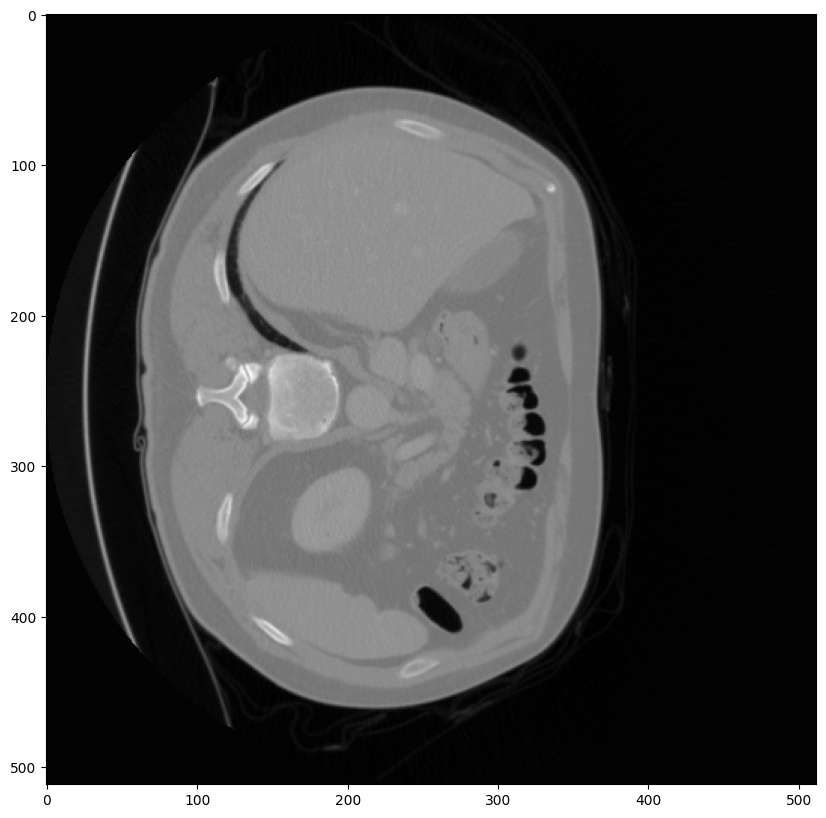

In [ ]:
# 使用模型进行预测
nii_file = nib.load('RawData/Training/imagesTr/img0031.nii.gz')
# 获取数据
data = nii_file.get_fdata()


# 归一化切片数据到0-255
slice_normalized = cv2.normalize(data[:,:,50], None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
slice_8bit = np.uint8(slice_normalized)
slice_bgr = cv2.cvtColor(slice_8bit, cv2.COLOR_GRAY2BGR)

plt.figure(figsize=(10,10))
plt.imshow(slice_bgr)
plt.axis('on')
plt.show()

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"



sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

predictor.set_image(slice_bgr)

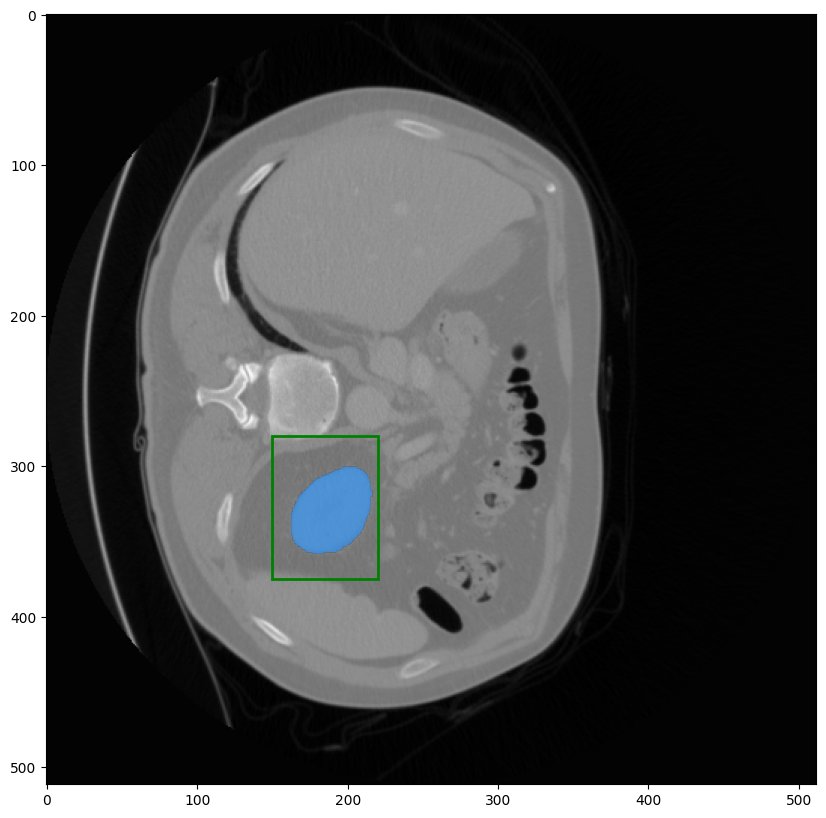

1/1 [==============================] - 0s 76ms/step
Predicted label: [47]


In [ ]:
input_box = np.array([150, 280, 220, 375])

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(slice_bgr)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('on')
plt.show()


image = np.array(masks[0])

label = predict_image(model, image)
print("Predicted label:", label)